In [1]:
# numpy and other basics
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import random as random
import math as math
%matplotlib inline

'''
# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid, softmax
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
''';

# theory

## derivatives of output layer versus $m$th layer weights $W^{(m)}_{\mu\nu}$

Here, $i$ indicates the element of the training set and $j$ indicates which neuron in the output layer we are examining

### $\frac{\partial a_{ij}^{(n)}}{\partial W_{\mu \nu}^{(n-k)}} = h'(z_{ij}^{(n)})\left[ \sum_{\alpha_1, \dots, \alpha_{k-1}} W_{j\alpha_1}^{(n)}g'(z_{i\alpha_1}^{(n-1)}) \dots W_{\alpha_{\beta}\alpha_{\beta+1}}^{(n-\beta)}g'(z_{i\alpha_{\beta+1}}^{(n-\beta-1)})\dots W_{\alpha_{k-1}\mu}^{(n-k+1)}g'(z_{i\mu}^{(n-k)})\right]a_{i\nu}^{(n-k-1)}$

### define matrices $\alpha^{(m)}$ such that $\left( \alpha^{(m)} \right)_{ijk} \equiv W^{(m)}_{jk} g'(z_{ik}^{(m-1)})$

Can calculate $\alpha^{(m)}$ by tiling the array $z$.  $z$ is an $(\gamma_1, \gamma_2, 1)$ array for $\gamma_1$ the number of examples in the input set and $\gamma_2$ the number of neurons in layer $(m-1)$.  Tile it out with $z_{tile} = $ np.tile(z, (1, 1, $n$)) for $n$ the number of rows of $W$ and then do a broadcast multiplication $\alpha$ = W * np.transpose(g'($z_{tile}$), (0, 2, 1))

### define matrix $\Lambda_{ijk}^{(n-k)}$ such that $\Lambda_{ijk}^{(n-k)} = \left( \prod_{\ell=0}^{k-1} \alpha^{(n-\ell)}(i,:,:) \right)_{jk}$

with MATLAB notation for the elements of the $\alpha$s, i.e. $\alpha(i,:,:)$ is the $i$th slice of $\alpha$ corresponding to the $i$th element of the ensemble

### note that for $k = 0$, $\Lambda^{(n)}(i,:,:) = I$ (square, size of output) and for $k = 1$, $\Lambda^{(n-1)}(i,:,:) = \alpha^{(n)}(i,:,:)$

### gives us new shorthand definition for gradients

### $\frac{\partial a_{ij}^{(n)}}{\partial W_{\mu \nu}^{(n-k)}} = h'(z_{ij}^{(n)}) \Lambda^{(n-k)}_{ij\mu} a_{i\nu}^{(n-k-1)}$

## gradients of cost function $J = \sum_i \sum_j L(a^{(n)}_{ij})$ for loss function $L$

### $\frac{\partial J}{\partial W_{\mu\nu}^{(n-k)}} = \sum_i \sum_j L'(a_{ij}^{(n)}) \frac{\partial a_{ij}^{(n)}}{\partial W_{\mu\nu}^{(n-k)}} = \sum_i \left[ \sum_j L'(a_{ij}^{(n)}) h'(z_{ij}^{(n)}) \Lambda^{(n-k)}_{ij\mu} \right] a_{i\nu}^{(n-k-1)}$

### define a new matrix $\eta$ such that $(\eta)_{ij} = L'(a_{ij}^{(n)}) h'(z_{ij}^{(n)})$

### $\frac{\partial J}{\partial W_{\mu\nu}^{(n-k)}} = \sum_i \left[ \sum_j \eta_{ij} \Lambda^{(n-k)}_{ij\mu} \right] a_{i\nu}^{(n-k-1)}$

Transpose $\Lambda_{ij\mu}^{(n-k)}$ by cycling 1 and 2 axes: $\Lambda^{(n-k), T}$ = np.transpose($\Lambda^{(n-k)}$, (0, 2, 1)) giving us

### $\frac{\partial J}{\partial W_{\mu\nu}^{(n-k)}} = \sum_i \left[ \sum_j \Lambda^{(n-k), T}_{i\mu j} \eta_{ij} \right] a_{i\nu}^{(n-k-1)}$

Term in brackets with sum over $j$ can be calculated with numpy multiplication of $\Lambda$ and $\eta$, let that be $\Delta$.  Gives us

### $\frac{\partial J}{\partial W_{\mu\nu}^{(n-k)}} = \sum_i \Delta_{i\mu} a_{i\nu}^{(n-k-1)}$

This term is obviously a matrix multiplication of $\Delta^T$ and $a$.  Finally arrive at

### gives us shorthand for gradient

### $\frac{\partial J}{\partial W_{\mu\nu}^{(n-k)}} = (\Delta^T a^{(n-k-1)})_{\mu \nu} $

## procedure to calculate gradients wrt weights

0) calculate necessary quantities, aka $z$ and $a$ values for each layer

1) calculate matrices $\alpha^{(m)}$

2) calculate matrices $\Lambda^{(n-k)}$

3) calculate matrix $\eta$

4) calculate matrix $\Delta$

5) calculate gradients

## gradients of biases

By the same process as before, can arrive at

### $\frac{\partial a_{ij}^{(n)}}{\partial B_{\mu}^{(n-k)}} = h'(z_{ij}^{(n)})\left[ \sum_{\alpha_1, \dots, \alpha_{k-1}} W_{j\alpha_1}^{(n)}g'(z_{i\alpha_1}^{(n-1)}) \dots W_{\alpha_{\beta}\alpha_{\beta+1}}^{(n-\beta)}g'(z_{i\alpha_{\beta+1}}^{(n-\beta-1)})\dots W_{\alpha_{k-1}\mu}^{(n-k+1)}g'(z_{i\mu}^{(n-k)})\right]$

and therefore

### $\frac{\partial a_{ij}^{(n)}}{\partial B_{\mu}^{(n-k)}} = h'(z_{ij}^{(n)}) \Lambda^{(n-k)}_{ij\mu}$

follow this to the end to get

### $\frac{\partial J}{\partial B_{\mu}^{(n-k)}} = \sum_i \Delta_{i\mu}$

## attempt to learn a basic problem

In [2]:
# load data from csv
train_data_set = genfromtxt('training_data.csv', delimiter=',')
test_data_set = genfromtxt('test_data.csv', delimiter=',')

The training inputs has shape (42000, 784, 1)
The true outputs have shape (42000, 10, 1)
The testing inputs has shape (28000, 784, 1)


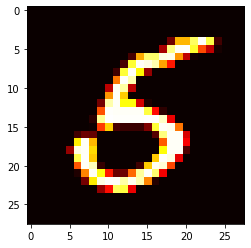

True label for this image is: 5.0


In [3]:
# get rid of first row (expand dims to fit network requirements)
train_data_set = train_data_set[1:np.shape(train_data_set)[0], :]
test_data = np.expand_dims(test_data_set[1:np.shape(test_data_set)[0], :], axis = 2)

# separate labels and data
train_labels = np.expand_dims(train_data_set[:,0], axis = 1)
train_data = np.expand_dims(train_data_set[:,1:np.shape(train_data_set)[1]], axis = 2)

# reshape training labels to be the right shape
true_labels = np.zeros((np.shape(train_labels)[0], 10, 1))
for idx in range(np.shape(train_labels)[0]):
    true_labels[idx, int(train_labels[idx][0])] = 1

# display size of data
print(f'The training inputs has shape {np.shape(train_data)}')
print(f'The true outputs have shape {np.shape(true_labels)}')
print(f'The testing inputs has shape {np.shape(test_data)}')

# dispay a random training data point and label
idx = random.randint(0, np.shape(train_data_set)[0])
x = np.reshape(train_data[idx,:], (28, 28))
x_label = train_labels[idx][0]
plt.imshow(x, cmap='hot', interpolation='nearest')
plt.show()
print(f'True label for this image is: {x_label}')

In [124]:
# reload numpy net
import importlib
import numpy_net_class
importlib.reload(numpy_net_class)
from numpy_net_class import *

# create network
np_net = numpy_net([28*28, 100, 25, 10], 'reLU', 'soft_max', 'cross_entropy', 'cross_entropy')

# load data
np_net.load_data_set(train_data, true_labels, test_data)

# check layer activations
# np_net.a0 = np_net.train_input[0:100,:]
# np_net.y = np_net.train_output[0:100,:]

In [125]:
# parameters of training
n_epochs = 10
batch_size = int(np.shape(train_data)[0] / 100)
learn_rate = 0.01

# train
np_net.train_network(n_epochs, batch_size, learn_rate)

Epoch 0 ====== Current Cost: 15.36999
Epoch 1 ====== Current Cost: 40.02176
Epoch 2 ====== Current Cost: 146.98145
Epoch 3 ====== Current Cost: inf
we borked it


In [1799]:
np_net.calculate_gradJ()

In [1800]:
# grab quantities we want
np_net.calculate_layer_activations()
tA = np_net.A
tZ = np_net.Z
ty = np_net.train_output

# calculate gradients by hand
t_dJdW = np.zeros(np.shape(np_net.weights[-1]))
a_iν = tA[2]

for μ in range(np.shape(np_net.weights[-1])[0]):
    for ν in range(np.shape(np_net.weights[-1])[1]):
        
        for i in range(np.shape(tA[-1])[0]):
            for j in range(np.shape(tA[-1])[1]):
                
                t_dJdW[μ,ν] += ((1/np.shape(tA[-1])[0]) * (tA[-1][i,j] - ty[i,j]) * a_iν[i,ν] * np.where(j == μ, 1.0, 0.0))

In [1801]:
print(np_net.dJdW[-1][:,0])
print(t_dJdW[:,0])

[ 43.16218776 -53.16180232 -67.27862259  39.75467639 -99.70995181
  35.64353337 -42.2595555   74.93993368 -55.98134749 -87.2838464 ]
[ 43.16218776 -53.16180232 -67.27862259  39.75467639 -99.70995181
  35.64353337 -42.2595555   74.93993368 -55.98134749 -87.2838464 ]


In [ ]:
# parameters of training
n_epochs = 10
batch_size = int(np.shape(train_data)[0] / 100)
learn_rate = 0.01

# train
np_net.train_network(n_epochs, batch_size, learn_rate)

## testing ground for class version

In [61]:
idx = random.randint(0, nsamps-1)

z = test_net.Z[-1]
af = test_net.A[-1]
Λ = test_net.Λ
for x in Λ:
    print(np.shape(x))
print()
# print(np.shape(z))

# make the exponential term
zT = np.transpose(z, (0,2,1))
# print(np.shape(zT))
δz = z - zT
print(np.shape(δz))
print()

# check δz, indexing is (i, ℓ, j) relative to write up
for ntrials in range(5000):
    
    idx = random.randint(0, nsamps - 1)
    i = random.randint(0, np.shape(z)[1] - 1)
    j = random.randint(0, np.shape(z)[1] - 1)

    if not np.isclose(δz[idx,i,j], z[idx,i] - z[idx,j]):
        print(δz[idx,i,j])
        print(z[idx,j] - z[idx,i])
        break
        
# δz indexing (i, ℓ, j), Λ indexing (i, ℓ, μ)
Γ = []
for i in range(len(Λ)):
    tΓ = np.matmul(np.transpose(δz, (0, 2, 1)), Λ[i]) * af
    print(np.shape(tΓ))
    Γ.append(np.copy(tΓ))
print()

# check Γ, indexing is (i, j, μ)
for ntrails in range(5000):
    
    layer = random.randint(0, len(Λ)-1)
    i = random.randint(0, nsamps - 1)
    j = random.randint(0, np.shape(z)[1] - 1)
    μ = random.randint(0, np.shape(z)[1] - 1)
    
    tΛ = 0
    for ℓ in range(10):
        tΛ += δz[i,ℓ,j] * Λ[layer][i,ℓ,μ] * af[i,j]
        
    if not np.isclose(tΛ, Γ[layer][i,j,μ]):
        print(tΛ)
        print(Γ[layer][i,j,μ])
        break
        
# elementwise multiply by a_ij
ξ = []
for idx in range(len(Γ)):
    
    ξ.append(Γ[idx] * af)
    print(np.shape(ξ[idx]))
    
# check ξ, indexing (i,j,μ)
for ntrials in range(5000):
    
    layer = random.randint(0, len(ξ) - 1)
    i = random.randint(0, nsamps - 1)
    j = random.randint(0, np.shape(af)[1] - 1)
    μ = random.randint(0, np.shape(Γ[layer])[2] - 1)
    
    tΛ = 0
    for ℓ in range(10):
        tΛ += δz[i,ℓ,j] * Λ[layer][i,ℓ,μ]
    
    if not np.isclose(Γ[layer][i,j,μ], af[i,j] * tΛ):
        print(ξ[layer][i,j,μ])
        print(af[i,j] * Γ[layer][i,j,μ])
        break
        
Σ

(50, 10, 100)
(50, 10, 25)
(50, 10, 10)

(50, 10, 10)

(50, 10, 100)
(50, 10, 25)
(50, 10, 10)

(50, 10, 100)
(50, 10, 25)
(50, 10, 10)


In [ ]:
for ntrials in range(5000):
    
    idx = random.randint(0, nsamps - 1)
    i = random.randint(0, np.shape(z)[1] - 1)
    j = random.randint(0, np.shape(z)[1] - 1)

    if np.array_equal(z_ij[idx,:,i], z_ij[idx,:,j]):
        print("bruh")

In [84]:
idx = random.randint(0, nsamps-1)

af = test_net.A[-1]
Λ = test_net.Λ
for x in Λ:
    print(np.shape(x))
print()
        
# δz indexing (i, ℓ, j), Λ indexing (i, ℓ, μ)
Γ = []
for i in range(len(Λ)):
    tΓ = np.matmul(np.transpose(Λ[i], (0, 2, 1)), af)
    print(np.shape(tΓ))
    Γ.append(np.copy(tΓ))
print()

# check Γ, indexing is (i, j, μ)
for ntrails in range(5000):
    
    layer = random.randint(0, len(Λ)-1)
    i = random.randint(0, nsamps - 1)
    μ = random.randint(0, np.shape(Λ[layer])[2] - 1)
    
    tΛ = 0
    for ℓ in range(10):
        tΛ += Λ[layer][i,ℓ,μ] * af[i,ℓ]
        
    if not np.isclose(tΛ, Γ[layer][i,μ]):
        print(tΛ)
        print(Γ[layer][i,μ])
        break
        
# subtract off
ξ = []
for idx in range(len(Λ)):
    ξ.append(Λ[idx] - np.transpose(Γ[idx], (0,2,1)))
    
# check ξ
for ntrails in range(5000):
    
    layer = random.randint(0, len(Λ) - 1)
    i = random.randint(0, nsamps - 1)
    j = random.randint(0, np.shape(af)[1] - 1)
    μ = random.randint(0, np.shape(Λ[layer])[2] - 1)
    
    if not np.isclose(ξ[layer][i,j,μ], Λ[layer][i,j,μ] - Γ[layer][i,μ]):
        print(ξ[layer][i,j,μ])
        print(Λ[layer][i,j,μ] - Γ[layer][i,μ])
        break

(50, 10, 100)
(50, 10, 25)
(50, 10, 10)

(50, 100, 1)
(50, 25, 1)
(50, 10, 1)



In [21]:
# run it with the network
import importlib
import numpy_net_class
importlib.reload(numpy_net_class)
from numpy_net_class import *
import copy

# size of input
input_sz = 28*28

# activation, loss functions
g_func = 'reLU'
h_func = 'soft_max'
JL_func = 'cross_entropy'

'''
μ_n0p1 = 0
μ_n1p0 = 0

σ_n0p1 = 0
σ_n1p0 = 0
'''

for ntrials in range(1):

    # create network
    test_net = numpy_net([input_sz, 100, 25, 10], g_func, h_func, JL_func, JL_func)

    # fetch weights, put into separate list for resetting
    W = []
    B = []
    for idx in range(len(test_net.weights)):
        W.append(np.copy(test_net.weights[idx]))
        B.append(np.copy(test_net.biases[idx]))

    # initialize with subset of data (randomly select 50 training examples)
    nsamps = 2;
    batch_idx = random.sample(range(0, np.shape(train_data)[0]), nsamps)

    # set a0, y
    a0 = train_data[batch_idx,:]
    y = true_labels[batch_idx,:]

    # assign
    test_net.a0 = a0
    test_net.y = y

    # calculate gradients
    test_net.calculate_gradJ()

    # small shift for gradients
    p = 9
    dWk_ij = np.random.uniform(1 / (10 ** p), 1 / (10 ** (p - 1)), 1)[0]

    # to save info
    dJdW = []

    # loop over the layers
    for k in range(len(W)):

        # calculated grads
        t_dJdW = np.zeros((np.shape(W[k])[0], np.shape(W[k])[1]))

        # loop over elements of weights
        for i in range(np.shape(W[k])[0]):
            for j in range(np.shape(W[k])[1]):

                # reset weights and biases
                t_W = copy.deepcopy(W)
                t_B = copy.deepcopy(B)

                # small adjustment
                t_W[k][i,j] -= dWk_ij

                # predict
                t_a0 = copy.deepcopy(a0)
                for idx in range(len(t_W)-1):

                    # apply weights
                    t_a0 = g(np.matmul(t_W[idx], t_a0) + t_B[idx], g_func)

                # final output
                t_a0 = np.matmul(t_W[-1], t_a0) + t_B[-1]
                t_af = g(t_a0, h_func)

                # calculate cost
                J0 = J(t_af, y, JL_func)

                # small adjustment
                t_W = copy.deepcopy(W)
                t_W[k][i,j] += dWk_ij

                # predict
                t_a0 = copy.deepcopy(a0)
                for idx in range(len(t_W)-1):

                    # apply weights
                    t_a0 = g(np.matmul(t_W[idx], t_a0) + t_B[idx], g_func)

                # final output
                t_a0 = np.matmul(t_W[-1], t_a0) + t_B[-1]
                t_af = g(t_a0, h_func)

                # calculate cost
                Jf = J(t_af, y, JL_func)

                # calculate approximate gradient
                t_dJdW[i,j] = (Jf-J0)/(2 * dWk_ij)

        dJdW.append(np.copy(t_dJdW))

    δ = []
    for k in range(len(W)):
        μval = (np.abs(test_net.dJdW[k]) + np.abs(dJdW[k])) / 2
        μval = np.where(μval > 0.0, μval, 1.0)
        δ.append(np.abs(test_net.dJdW[k] - dJdW[k]) / μval)

    for k in range(len(W)):

        # want to only look at places where they are not identically zero from the reLU
        t_bool = (dJdW[k] != 0) | (test_net.dJdW[k] != 0)

        print(f'The mean value of the error in weights for layer {k+1} is {100 * np.average(δ[k][t_bool]):.10f}%')
        print(f'The standard deviation of the error in weights for layer {k+1} is {100 * np.std(δ[k][t_bool]):.10f}%')
        print(f'The median value of the error in weights for layer {k+1} is {100 * np.median(δ[k][t_bool]):.10f}%')
        print()
       
    '''
    t_bool1 = (dJdW[0] != 0) | (test_net.dJdW[0] != 0)
    t_bool2 = (dJdW[1] != 0) | (test_net.dJdW[1] != 0)
        
    if (100 * np.average(δ[0][t_bool1]) > 0.1) | (100 * np.average(δ[1][t_bool2]) > 0.1):
        μ_n0p1 += 1
        if (100 * np.average(δ[0][t_bool1]) > 1) | (100 * np.average(δ[1][t_bool2]) > 1):
            μ_n1p0 += 1
            
    if (100 * np.std(δ[0][t_bool1]) > 0.1) | (100 * np.std(δ[1][t_bool2]) > 0.1):
        σ_n0p1 += 1
        if (100 * np.std(δ[0][t_bool1]) > 1) | (100 * np.std(δ[1][t_bool2]) > 1):
            σ_n1p0 += 1        
    # print("|=======================================================================================================|")
    
print(f'Number of instances with average error in layers 1 and 2 greater than 0.1%: {μ_n0p1}')
print(f'Number of instances with average error in layers 1 and 2 greater than 1.0%: {μ_n1p0}')
print()
print(f'Number of instances with standard deviation in error in layers 1 and 2 greater than 0.1%: {σ_n0p1}')
print(f'Number of instances with standard deviation in error in layers 1 and 2 greater than 1.0%: {σ_n1p0}') 
'''

The mean value of the error in weights for layer 1 is 0.0001375311%
The standard deviation of the error in weights for layer 1 is 0.0031890041%
The median value of the error in weights for layer 1 is 0.0000052368%

The mean value of the error in weights for layer 2 is 0.0000412847%
The standard deviation of the error in weights for layer 2 is 0.0002229049%
The median value of the error in weights for layer 2 is 0.0000053616%

The mean value of the error in weights for layer 3 is 100.0671489692%
The standard deviation of the error in weights for layer 3 is 99.9337397358%
The median value of the error in weights for layer 3 is 102.6909909759%



In [12]:
# run it with the network
import importlib
import numpy_net_class
importlib.reload(numpy_net_class)
from numpy_net_class import *
import copy

# size of input
input_sz = 28*28

# activation, loss functions
g_func = 'reLU'
h_func = 'soft_max'
JL_func = 'cross_entropy'

# create network
test_net = numpy_net([input_sz, 100, 25, 10], g_func, h_func, JL_func, JL_func)

# fetch weights, put into separate list for resetting
W = []
B = []
for idx in range(len(test_net.weights)):
    W.append(np.copy(test_net.weights[idx]))
    B.append(np.copy(test_net.biases[idx]))

# initialize with subset of data (randomly select 50 training examples)
nsamps = 50;
batch_idx = random.sample(range(0, np.shape(train_data)[0]), nsamps)

# set a0, y
a0 = train_data[batch_idx,:]
y = true_labels[batch_idx,:]

# assign
test_net.a0 = a0
test_net.y = y

# calculate gradients
test_net.calculate_gradJ()

# small shift for gradients
p = 9
dBk_i = np.random.uniform(1 / (10 ** p), 1 / (10 ** (p - 1)), 1)[0]

# to save info
dJdB = []

# loop over the layers
for k in range(len(B)):

    # calculated grads
    t_dJdB = np.zeros((np.shape(B[k])[0], 1))

    # loop over elements of weights
    for i in range(np.shape(B[k])[0]):

        # reset weights and biases
        t_W = copy.deepcopy(W)
        t_B = copy.deepcopy(B)

        # small adjustment
        t_B[k][i] -= dBk_i

        # predict
        t_a0 = copy.deepcopy(a0)
        for idx in range(len(t_W)-1):

            # apply weights
            t_a0 = g(np.matmul(t_W[idx], t_a0) + t_B[idx], g_func)

        # final output
        t_a0 = np.matmul(t_W[-1], t_a0) + t_B[-1]
        t_af = g(t_a0, h_func)

        # calculate cost
        J0 = J(t_af, y, JL_func)

        # small adjustment
        t_B = copy.deepcopy(B)
        t_B[k][i] += dBk_i

        # predict
        t_a0 = copy.deepcopy(a0)
        for idx in range(len(t_W)-1):

            # apply weights
            t_a0 = g(np.matmul(t_W[idx], t_a0) + t_B[idx], g_func)

        # final output
        t_a0 = np.matmul(t_W[-1], t_a0) + t_B[-1]
        t_af = g(t_a0, h_func)

        # calculate cost
        Jf = J(t_af, y, JL_func)

        # calculate approximate gradient
        t_dJdB[i] = (Jf-J0)/(2 * dBk_i)
            
    dJdB.append(np.copy(t_dJdB))

δ = []
for k in range(len(W)):
    μval = (np.abs(test_net.dJdB[k]) + np.abs(dJdB[k])) / 2
    μval = np.where(μval > 0.0, μval, 1.0)
    δ.append(np.abs(test_net.dJdB[k] - dJdB[k]) / μval)

for k in range(len(W)):
    
    # want to only look at places where they are not identically zero from the reLU
    t_bool = (dJdB[k] != 0) | (test_net.dJdB[k] != 0)
    
    print(f'The mean value of the error in weights for layer {k+1} is {100 * np.average(δ[k][t_bool]):.10f}%')
    print(f'The standard deviation of the error in weights for layer {k+1} is {100 * np.std(δ[k][t_bool]):.10f}%')
    print(f'The median value of the error in weights for layer {k+1} is {100 * np.median(δ[k][t_bool]):.10f}%')
    print()

The mean value of the error in weights for layer 1 is 0.0167238755%
The standard deviation of the error in weights for layer 1 is 0.0288447438%
The median value of the error in weights for layer 1 is 0.0062831091%

The mean value of the error in weights for layer 2 is 0.0078626281%
The standard deviation of the error in weights for layer 2 is 0.0121532246%
The median value of the error in weights for layer 2 is 0.0017138665%

The mean value of the error in weights for layer 3 is 0.0004516266%
The standard deviation of the error in weights for layer 3 is 0.0004121857%
The median value of the error in weights for layer 3 is 0.0003131859%



In [6]:
def J(a, y, func):

    # mean square error
    if func == 'mean_square_error':
        return (1/(2 * np.shape(a)[0])) * np.sum(np.square(a - y))

    # soft max
    elif func == 'cross_entropy':

        # adjust a to filter really small values
        # t_a = np.where(a > 10**-20, a, 10**-20)

        # filter to make sure rounding doesn't mess with us
        t_L = np.where(y > 0.5, -y * np.log(a), 0.0)

        # do the sum
        return np.sum(t_L) / np.shape(a)[0]

    # default to mse
    else:
        return (1/(2 * np.shape(a)[0])) * np.sum(np.square(a - y))
    
def g(z, func):

    # linear
    if func == 'linear':
        return z

    # sigmod
    elif func == 'sigmoid':
        return 1/(1 + np.exp(-z))

    # reLU
    elif func == 'reLU':
        return np.where(z > 0.0, z, 0.0)

    # softmax
    elif func == 'soft_max':

        # calculate max z value to shift everything
        z_max = np.reshape(np.amax(z, axis = 1), (np.shape(z)[0], 1, 1))

        # calculate exponents
        exp_z = np.exp(z - z_max)

        # calculate slice sums (have to do some reshaping for broadcasting
        sum_exp_z = np.reshape(np.sum(exp_z, axis = 1), (np.shape(exp_z)[0], 1, 1))

        # combine
        return exp_z / sum_exp_z

    # default to reLU for all other inputs
    else:
        return np.where(z > 0.0, z, 0.0)

In [1879]:
# run it with the network
import importlib
import numpy_net_class
importlib.reload(numpy_net_class)
from numpy_net_class import *
import copy

# size of input
input_sz = 28*28

# activation, loss functions
g_func = 'reLU'
h_func = 'soft_max'
JL_func = 'cross_entropy'

# create network
test_net = numpy_net([input_sz, 100, 25, 10], g_func, h_func, JL_func, JL_func)

# fetch weights, put into separate list for resetting
W = []
B = []
for idx in range(len(test_net.weights)):
    W.append(np.copy(test_net.weights[idx]))
    B.append(np.copy(test_net.biases[idx]))

# initialize with subset of data (randomly select 50 training examples)
nsamps = 50;
batch_idx = random.sample(range(0, np.shape(train_data)[0]), nsamps)

# set a0, y
a0 = train_data[batch_idx,:]
y = true_labels[batch_idx,:]

# assign
test_net.a0 = a0
test_net.y = y

# calculate gradients
test_net.calculate_gradJ()

##############################################################################################################################
##############################################################################################################################

# small shift for gradients
p = 9
dWk_ij = np.random.uniform(1 / (10 ** p), 1 / (10 ** (p - 1)), 1)[0]

# to save info
dJdW = []

# loop over the layers
for k in range(len(W)):

    # calculated grads
    t_dJdW = np.zeros((np.shape(W[k])[0], np.shape(W[k])[1]))

    # loop over elements of weights
    for i in range(np.shape(W[k])[0]):
        for j in range(np.shape(W[k])[1]):

            # reset weights and biases
            t_W = copy.deepcopy(W)
            t_B = copy.deepcopy(B)

            # small adjustment
            t_W[k][i,j] -= dWk_ij

            # predict
            t_a0 = copy.deepcopy(a0)
            for idx in range(len(t_W)-1):

                # apply weights
                t_a0 = g(np.matmul(t_W[idx], t_a0) + t_B[idx], g_func)

            # final output
            t_a0 = np.matmul(t_W[-1], t_a0) + t_B[-1]
            t_af = g(t_a0, h_func)

            # calculate cost
            J0 = J(t_af, y, JL_func)

            # small adjustment
            t_W = copy.deepcopy(W)
            t_W[k][i,j] += dWk_ij

            # predict
            t_a0 = copy.deepcopy(a0)
            for idx in range(len(t_W)-1):

                # apply weights
                t_a0 = g(np.matmul(t_W[idx], t_a0) + t_B[idx], g_func)

            # final output
            t_a0 = np.matmul(t_W[-1], t_a0) + t_B[-1]
            t_af = g(t_a0, h_func)

            # calculate cost
            Jf = J(t_af, y, JL_func)

            # calculate approximate gradient
            t_dJdW[i,j] = (Jf-J0)/(2 * dWk_ij)
            
    dJdW.append(np.copy(t_dJdW))

δ = []
for k in range(len(W)):
    μval = (np.abs(test_net.dJdW[k]) + np.abs(dJdW[k])) / 2
    μval = np.where(μval > 0.0, μval, 1.0)
    δ.append(np.abs(test_net.dJdW[k] - dJdW[k]) / μval)

for k in range(len(W)):
    
    # want to only look at places where they are not identically zero from the reLU
    t_bool = (dJdW[k] != 0) & (test_net.dJdW[k] != 0)
    
    print(f'The mean value of the error in weights for layer {k+1} is {100 * np.average(δ[k][t_bool]):.10f}%')
    print(f'The standard deviation of the error in weights for layer {k+1} is {100 * np.std(δ[k][t_bool]):.10f}%')
    print(f'The median value of the error in weights for layer {k+1} is {100 * np.median(δ[k][t_bool]):.10f}%')
    print()

(500, 784, 1)
(500, 1, 1)
(500, 784, 1)
(500, 1, 1)
(500, 784, 1)


# with tensorflow

In [ ]:
# same but with tensorflow
model = Sequential([        
    tf.keras.layers.InputLayer(input_shape = (28*28,)),
    tf.keras.layers.Dense(units = 50, activation = 'relu', name = "L1"),
    tf.keras.layers.Dense(units = 25, activation = 'relu', name = "L2"),
    tf.keras.layers.Dense(units = 10, activation = 'softmax', name = "L3")
    ], name = "my_model")

model.build()
model.summary()

model.compile(
    loss = CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

In [ ]:
# load data from csv
train_data_set = genfromtxt('training_data.csv', delimiter=',')
test_data_set = genfromtxt('test_data.csv', delimiter=',')

# clear first row
train_data_set = train_data_set[1:np.shape(train_data_set)[0], :]

# separate labels and data
train_labels = train_data_set[:,0]
train_data = train_data_set[:,1:np.shape(train_data_set)[1]] / 255.0 # normalize

# reshape training labels to be the right shape
true_labels = np.zeros((np.shape(train_labels)[0], 10,))
for idx in range(np.shape(train_labels)[0]):
    true_labels[idx, int(train_labels[idx])] = 1

In [ ]:
model.fit(train_data, true_labels, epochs=10)